# Model Explainability
In this step we reuse some code [from step 2](../02-sagemaker-containers.ipynb) to inspect our model with SageMaker Clarify both in batch inference as in a real-time endpoint. 

![](img/six-steps-2.png)

Model explainability has become a critical topic in the field of artificial intelligence, as the complexity of machine learning models has increased rapidly. Explainability refers to the ability to understand and interpret the decision-making process of a model, which is essential in making informed decisions and gaining trust in the model's predictions. SHAP (Shapley Additive Explanations) is a popular method for model explainability that has gained significant attention in recent years.

SHAP is a unified framework that provides a game-theoretic approach to explain the output of any machine learning model. It uses Shapley values, a concept from cooperative game theory, to attribute the contribution of each feature to the model's output. SHAP has been shown to be effective in providing both global and local interpretability, allowing users to understand the overall behavior of the model and the reasoning behind specific predictions.

However, the computational problem of SHAP lies in its complexity. SHAP values require the computation of all possible coalitions of features, which is an NP-hard problem. To address this challenge, several approximation methods have been proposed, including Kernel SHAP, Tree SHAP, and Deep SHAP. These methods use different techniques to approximate the SHAP values efficiently and accurately, making SHAP a practical solution for model explainability in real-world scenarios.

SageMaker Clarify addresses this issue by providing a distributed and scalable implementation of SHAP that runs on Apache Spark in the background. It uses a processing job to run the SHAP algorithm on a cluster of EC2 instances, enabling the computation of SHAP values to be distributed across multiple nodes. This greatly reduces the time required for SHAP computations, making it practical to use for large datasets and complex models.

In [136]:
import time
import boto3
import botocore
import os
import numpy as np  
import pandas as pd  
import sagemaker
import io
from collections import OrderedDict
from time import gmtime, strftime, sleep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer, CSVDeserializer

json_deserializer = JSONDeserializer()
csv_serializer = CSVSerializer()
csv_deserializer = CSVDeserializer()

sagemaker.__version__

'2.142.0'

In [45]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                        -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
baseline_s3_url_catboost               -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
bucket_name                            -> 'sagemaker-us-east-1-510646607739'
bucket_prefix                          -> 'from-idea-to-prod/xgboost'
bucket_prefix_catboost                 -> 'from-idea-to-prod/catboost'
domain_id                              -> None
experiment_name                        -> 'Model-Improvement-Efforts-04-13-17-21'
initialized                            -> True
input_s3_url_catboost                  -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
output_s3_url                          -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
region                                 -> 'us-east-1'
sm_role                                -> 'arn:aws:iam::510646607739:role/service-role/Amazo
test_s3_url                            -> 's3:

In [46]:
session = sagemaker.Session()
sm = session.sagemaker_client

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Set the Amazon S3 paths:


In [47]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

In [48]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url
%store output_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)
Stored 'output_s3_url' (str)


## Model training
Follow the same approach and now run the model training as a [SageMaker training job](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators).

In [10]:
# get training container uri
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")

print(training_image)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


Define the data input channels for the training job. Set _train_ and _validation_ channels via the SageMaker SDK [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class:

In [11]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

In [12]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

Instantiate an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object and set algorithm's hyperparameters. Refer to [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information.

In [16]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    use_spot_instances=True,  # Use spot instances to reduce cost
    max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150, # the number of rounds to run the training
    max_depth=3, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

Run the training:

In [17]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [18]:
try:
    run_suffix = strftime('%Y-%m-%M-%S', gmtime())
    run_name = f"container-training-{run_suffix}"

    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name="container-training",
             sagemaker_session=session
            ) as run:
        
        estimator.fit(
            training_inputs,
            wait=True,
            logs=False,
        ) 
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2023-04-06-13-02-49-175



2023-04-06 13:02:49 Starting - Starting the training job...
2023-04-06 13:03:10 Starting - Preparing the instances for training........
2023-04-06 13:03:58 Downloading - Downloading input data.....
2023-04-06 13:04:29 Training - Downloading the training image...
2023-04-06 13:04:49 Training - Training image download completed. Training in progress...
2023-04-06 13:05:05 Uploading - Uploading generated training model.
2023-04-06 13:05:16 Completed - Training job completed


### Reduce training job startup time with warm pools
💡 Instead of using each time a new ephemeral computation cluster to train your models, you can keep your model training hardware instances warm after every job for a specified period. Refer to [Reduce ML Model Training Job startup time by up to 8x using SageMaker Training Managed Warm Pools](https://aws.amazon.com/about-aws/whats-new/2022/09/reduce-ml-model-training-job-startup-time-8x-sagemaker-training-managed-warm-pools/) for more details. If you opt to use warm pools, you are billed for the instances and EBS volumens for the duration of the keep-alive period. 
Refer to [ Train Using SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) in the Amazon SageMaker Developer Guide for details on training API.

### Output model performance

In [19]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

In [20]:
metrics = None
while not metrics:
    metrics = sm.describe_training_job(
        TrainingJobName=training_job_name
        ).get("FinalMetricDataList")

    if not metrics:
        print(f"Training job {training_job_name} hasn't finished yet!")
        time.sleep(10)
    
train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.2f}, Validate-auc:{validate_auc:.2f}")

Train-auc:0.79, Validate-auc:0.77


In [21]:
%store training_job_name

Stored 'training_job_name' (str)


In [22]:
# Print the S3 path to the model artifact:
estimator.model_data

's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/output/from-idea-to-prod-training-2023-04-06-13-02-49-175/output/model.tar.gz'

## Model-Explainability of a real-time endpoint
The training job saved a model in the specified location on Amazon S3.

You can deploy the model as a [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), which is just one [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), or create a [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict a label for a large dataset.

First we are going to look at real-time endpoint predictions. SageMaker Clarify gives you the option to explain every call to the endpoint. First, lets create an endpoint without SageMaker Clarify to investigate the difference in response. 


### Real-time inference
To test [real-time inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) you create a real-time endpoint using the trained estimator.

In [23]:
# Real-time endpoint
endpoint_name = f"from-idea-to-prod-endpoint-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    predictor = estimator.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.large",
        wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
        # Turn on data capture here, in case you want to experiment with monitoring:
        data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
            enable_capture=True,
            sampling_percentage=100,
            destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
        ),
        endpoint_name=endpoint_name,
        serializer=sagemaker.serializers.csv_serializer,
        deserializer=sagemaker.deserializers.CSVDeserializer(),
    )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
        predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name,
                                                  sagemaker_session=session,
                                                  serializer=sagemaker.serializers.csv_serializer,
                                                  deserializer=sagemaker.deserializers.CSVDeserializer(),
                                                 )
    else:
        raise e

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2023-04-06-13-17-46-312
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-06-13-17-46
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-06-13-17-46


In [24]:
# Wait until the endpoint has the status InService
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

#### Predict

In [25]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [49]:
test_x = pd.read_csv("tmp/test_x.csv", names=[f'{i}' for i in range(59)])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])
test_x.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,25,1,999,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,28,3,999,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,1,999,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,32,1,999,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,40,1,999,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [50]:
%%time
predictions = np.array(predictor.predict(test_x.values), dtype=float).squeeze()
print(f'Number of predictions made by the endpoint:{predictions.shape}\n')
print(f'Predictions made by the endpoint:{predictions}')

Number of predictions made by the endpoint:(4119,)

Predictions made by the endpoint:[0.06094802 0.09423219 0.20767137 ... 0.04564261 0.03911222 0.03352626]
CPU times: user 183 ms, sys: 33.4 ms, total: 216 ms
Wall time: 1.99 s


#### Evaluate predictions

In [51]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

,y_pred,0,1,2,3,4,5,6,7,8,...,49,50,51,52,53,54,55,56,57,58
0,0.060948,25,1,999,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.094232,28,3,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.207671,38,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.256129,32,1,999,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.039112,40,1,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [52]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [53]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


As we can see, are only the predictions from the endpoint have been returned. For many use cases, a batch calculation for model explainabilty is sufficient.


### Online explainability of an endpoint
For applications when using a human-in-the-loop, calculations need to be made at inference time. E.g. when human experts interact with customers, we want out model predictions to be as recent as possible, and the same holds ture for our model explanations. Therefore, we need to calculate those metrics at inference time. 

In our example, call center outbound calls, it is essential to provide the agent with information on what drives the customer to be targeted for marketing calls. Using machine learning models for this purpose can lead to improved targeting and better results. However, it is critical to explain the model's prediction to the agent to gain their trust and help them make informed decisions. 

Explanations are typically contrastive (that is, they account for deviations from a baseline). As a result, for the same model prediction, you can expect to get different explanations with respect to different baselines. Therefore, your choice of a baseline is crucial. In an ML context, the baseline corresponds to a hypothetical instance that can be either uninformative or informative. During the computation of Shapley values, SageMaker Clarify generates several new instances between the baseline and the given instance, in which the absence of a feature, is modeled by setting the feature value to that of the baseline and the presence of a feature is modeled by setting the feature value to that of the given instance. Thus, the absence of all features corresponds to the baseline and the presence of all features corresponds to the given instance.

How can you choose good baselines? Often it is desirable to select a baseline with very low information content. For example, you can construct an average instance from the training dataset by taking either the median or average for numerical features and the mode for categorical features. For the college admissions example, you might be interested in explaining why a particular applicant was accepted as compared to a baseline acceptances based on an average applicant. If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset.

Alternatively, you can choose to generate explanations with respect to informative baselines. For the college admissions scenario, you might want to explain why a particular applicant was rejected when compared with other applicants from similar demographic backgrounds. In this case, you can choose a baseline that represents the applicants of interest, namely those from a similar demographic background. Thus, you can use informative baselines to concentrate the analysis on the specific aspects of a particular model prediction. You can isolate the features for assessment by setting demographic attributes and other features that you can't act on to the same value as in the given instance.

Amazon Web Services. (n.d.). SageMaker Clarify SHAP: Choosing baselines and feature attributes. Retrieved April 6, 2023, from https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html 

For our case with the realtime inference we want to use the validation set as a baseline, as we would not have the test data available. 

In [32]:
# use the aws cli to get the validation testset downloaded with the s3 downloader
!aws s3 cp $validation_s3_url/validation.csv tmp/validation.csv

download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/validation/validation.csv to tmp/validation.csv


In [54]:
# read the validation testset into a pandas dataframe. there is no header in the csv file rename the columns by column number
validation_x = pd.read_csv("tmp/validation.csv", header=None).drop(0, axis=1)
print(validation_x.shape)

(8238, 59)


In [55]:
baseline = validation_x.mean().to_list()  # Inline baseline data
print(f"Baseline array shape to check: {np.array(baseline).shape}")
print(f"Use the mean of the test data as the SHAP baseline: {baseline[:5]}")

Baseline array shape to check: (59,)
Use the mean of the test data as the SHAP baseline: [40.09662539451323, 2.5648215586307357, 965.7171643602816, 0.16436028162175284, 0.9664967225054625]


In [62]:
from botocore.config import Config
sagemaker_client = boto3.client('sagemaker')

In [65]:
# in case you lost the endpoint name, you can get it from the sagemaker client
endpoint_list = sagemaker_client.list_endpoints()

# filter the endpoints list to get the endpoint name that has "from-idea-to-prod-endpoint" in the name
endpoint_name = [endpoint['EndpointName'] for endpoint in endpoint_list['Endpoints'] if 'from-idea-to-prod-endpoint' in endpoint['EndpointName']][0]
clarify_config_name = 'realtime-clarify-config'

# get the endpoint config name from the endpoint name
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_config_name = response['EndpointConfigName']


In [66]:
# lets take a look at the endpoint config
sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)

{'EndpointConfigName': 'from-idea-to-prod-endpoint-06-13-17-46',
 'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:510646607739:endpoint-config/from-idea-to-prod-endpoint-06-13-17-46',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'ModelName': 'from-idea-to-prod-training-2023-04-06-13-17-46-312',
   'InitialInstanceCount': 1,
   'InstanceType': 'ml.m5.large',
   'InitialVariantWeight': 1.0,
   'VolumeSizeInGB': 8}],
 'DataCaptureConfig': {'EnableCapture': True,
  'InitialSamplingPercentage': 100,
  'DestinationS3Uri': 's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/data-capture',
  'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}],
  'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv'],
   'JsonContentTypes': ['application/json']}},
 'CreationTime': datetime.datetime(2023, 4, 6, 15, 17, 48, 188000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '2d93c86d-b8e0-4dcb-85ff-e1cbdb0cbf25',
  'HTTPStatusCode': 200,
  'HTTPHeade

To acutally have human readable descriptions of the features, we need to tell clarify what are the feature header labels. Remember, we only pass a payload to the endpoint, that has no feature column namings. Due to our one-hot-encoding, we need to 

In [96]:
df_data = pd.read_csv("../data/bank-additional/bank-additional-full.csv", sep=";")
# Indicator variable to capture when pdays takes a value of 999
df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

# Indicator for individuals not actively employed
df_data["not_working"] = np.where(
    np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
)

# remove unnecessary data
df_model_data = df_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators
target_col = "y"
# Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
df_model_data = pd.concat(
    [
        df_model_data["y_yes"].rename(target_col),
        df_model_data.drop(["y_no", "y_yes"], axis=1),
    ],
    axis=1,
)

feature_headers = df_model_data.columns.tolist()
feature_headers = feature_headers[1:]
print(len(feature_headers))
print(feature_headers)
print(type(feature_headers))

59
['age', 'campaign', 'pdays', 'previous', 'no_previous_contact', 'not_working', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonex

In [97]:
response = sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
production_variants = response['ProductionVariants']
data_config = response['DataCaptureConfig']
explainer_config={
        "ClarifyExplainerConfig": {
            # "EnableExplanations": "`false`",  # By default explanations are enabled, but you can change the condition by this parameter.
            "InferenceConfig": {
                "FeatureHeaders": feature_headers,
            },
            "ShapConfig": {
                "ShapBaselineConfig": {
                    "ShapBaseline": CSVSerializer().serialize(baseline),  # inline baseline data
                }
            },
        }
    }
    
print(production_variants)
print(data_config)
print(explainer_config)


[{'VariantName': 'AllTraffic', 'ModelName': 'from-idea-to-prod-training-2023-04-06-13-17-46-312', 'InitialInstanceCount': 1, 'InstanceType': 'ml.m5.large', 'InitialVariantWeight': 1.0, 'VolumeSizeInGB': 8}]
{'EnableCapture': True, 'InitialSamplingPercentage': 100, 'DestinationS3Uri': 's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/data-capture', 'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}], 'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv'], 'JsonContentTypes': ['application/json']}}
{'ClarifyExplainerConfig': {'InferenceConfig': {'FeatureHeaders': ['age', 'campaign', 'pdays', 'previous', 'no_previous_contact', 'not_working', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'educati

In [99]:
new_endpoint_config_name = f"{endpoint_name}-new-config"
create_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=new_endpoint_config_name,
    ProductionVariants=production_variants,
    ExplainerConfig=explainer_config,
    )

In [101]:
create_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:510646607739:endpoint-config/from-idea-to-prod-endpoint-06-13-17-46-new-config',
 'ResponseMetadata': {'RequestId': 'afe09e35-3946-4110-9390-7102917f8c35',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'afe09e35-3946-4110-9390-7102917f8c35',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Fri, 07 Apr 2023 11:36:58 GMT'},
  'RetryAttempts': 0}}

In [104]:
endpoint_config_name = new_endpoint_config_name

In [107]:
sagemaker_client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)

In [108]:
def force_plot(expected_value, shap_values, feature_data, feature_headers):
    """
    Visualize the given SHAP values with an additive force layout.

    For more information: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html
    """
    force_plot_display = shap.plots.force(
        base_value=expected_value,
        shap_values=shap_values,
        features=feature_data,
        feature_names=feature_headers,
        matplotlib=True,
    )


def display_plots(explanations, expected_value, request_records, predictions):
    """
    Display the Model Explainability plots
    """
    per_request_shap_values = OrderedDict()
    feature_headers = []
    for i, record_output in enumerate(explanations):
        per_record_shap_values = []
        if record_output is not None:
            feature_headers = []
            for feature_attribution in record_output:
                per_record_shap_values.append(
                    feature_attribution["attributions"][0]["attribution"][0]
                )
                feature_headers.append(feature_attribution["feature_header"])
            per_request_shap_values[i] = per_record_shap_values

    for record_index, shap_values in per_request_shap_values.items():
        print(
            f"Visualize the SHAP values for Record number {record_index + 1} with Model Prediction: {predictions[record_index][0]}"
        )
        force_plot(
            expected_value,
            np.array(shap_values),
            request_records.iloc[record_index],
            feature_headers,
        )


def visualize_result(result, request_records, expected_value):
    """
    Visualize the output from the endpoint.
    """
    predictions = pd.read_csv(io.StringIO(result["predictions"]["data"]), header=None)
    predictions = predictions.values.tolist()
    print(f"Model Inference output: ")
    for i, model_output in enumerate(predictions):
        print(f"Record: {i + 1}\tModel Prediction: {model_output[0]}")

    if "kernel_shap" in result["explanations"]:
        explanations = result["explanations"]["kernel_shap"]
        display_plots(explanations, expected_value, request_records, predictions)
    else:
        print(f"No Clarify explanations for the record(s)")

In [ ]:
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.to_numpy()),
)
pprint.pprint(response)

In [120]:
test_x.values[0]

array([ 25,   1, 999,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         1,   0,   0,   0,   0,   1,   0])

In [151]:
import pprint
sagemaker_runtime_client = boto3.client("sagemaker-runtime")

request_records = test_x.iloc[:1, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.values),
)
pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x7fa939b74880>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '5623',
                                      'content-type': 'application/json',
                                      'date': 'Fri, 07 Apr 2023 12:14:04 GMT',
                                      'x-amzn-invoked-production-variant': 'AllTraffic',
                                      'x-amzn-requestid': 'b2c7e810-1158-456d-85e1-ae194d4df43f'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'b2c7e810-1158-456d-85e1-ae194d4df43f',
                      'RetryAttempts': 0}}


In [152]:
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
result

{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [0.027348084569765594]}],
     'feature_header': 'age'},
    {'attributions': [{'attribution': [1.901658631919996e-05]}],
     'feature_header': 'campaign'},
    {'attributions': [{'attribution': [0.0002652825661141993]}],
     'feature_header': 'pdays'},
    {'attributions': [{'attribution': [-0.00012108379350257714]}],
     'feature_header': 'previous'},
    {'attributions': [{'attribution': [-0.0002907941956844032]}],
     'feature_header': 'no_previous_contact'},
    {'attributions': [{'attribution': [-0.0002529469610192594]}],
     'feature_header': 'not_working'},
    {'attributions': [{'attribution': [-0.00015888284559720592]}],
     'feature_header': 'job_admin.'},
    {'attributions': [{'attribution': [0.00021397454913316344]}],
     'feature_header': 'job_blue-collar'},
    {'attributions': [{'attribution': [-0.0005699011621797291]}],
     'feature_header': 'job_entrepreneur'},
    {'attributions': [{'attrib

In [153]:
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(baseline),
    EnableExplanations="`false`",  # Do not provide explanations
)
json_object = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
expected_value = float(
    pd.read_csv(io.StringIO(json_object["predictions"]["data"]), header=None)
    .astype(float)
    .mean(axis=1)
)
print(f"expected value: {expected_value}")

expected value: 0.0805706828832626


Model Inference output: 
Record: 1	Model Prediction: 0.0609480179846286
Visualize the SHAP values for Record number 1 with Model Prediction: 0.0609480179846286


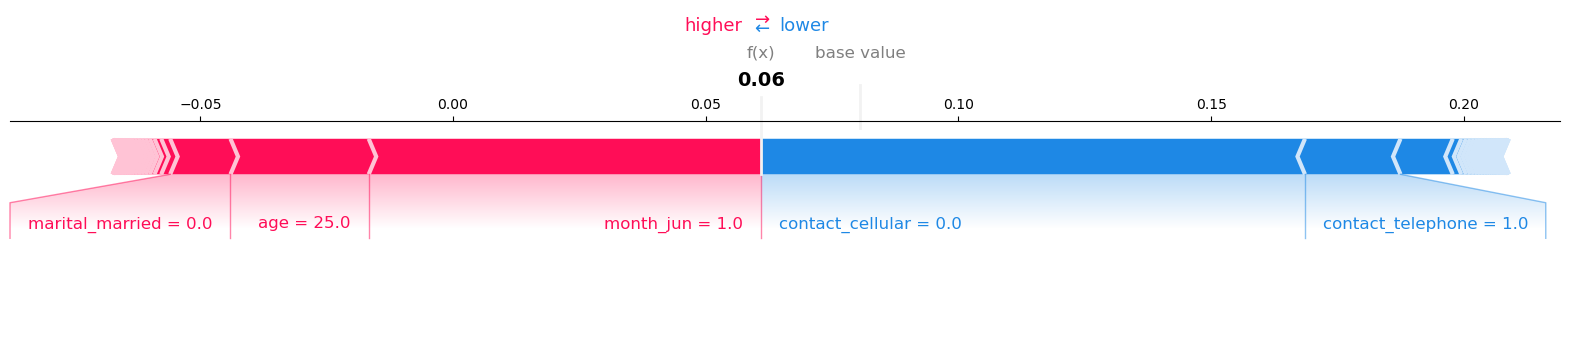

In [154]:
import shap 
visualize_result(result, request_records, expected_value)

### Batch transform
If you want to run a prediction on a large dataset or don't need a real-time endpoint, you can use SageMaker [batch-transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

In [38]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"

To create a transformer, use either option 1 or option 2.

#### Option 1: create a batch transformer from the trained estimator
You can use [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) to create a transformer for an estimator:

In [39]:
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer = estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-13-09-49-56


Go to the section **Run transform job**.

#### Option 2: load a model from a training job
Alternatively, you can load a model from a model artifact produced by a training job. You create a transformer with that model.

In [ ]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

In [ ]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

#### Run transform job

In [40]:
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    run_suffix = strftime('%Y-%m-%M-%S', gmtime())
    run_name = f"batch-transform-{run_suffix}"

    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name="batch-transform",
             sagemaker_session=session
            ) as run:
        transformer.transform(    
            data=f"{test_s3_url}/test_x.csv",
            content_type="text/csv",
            split_type="Line", 
            job_name=transform_job_name,
            wait=True,
            # experiment_config=experiment_config,
        )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating transform job with name: from-idea-to-prod-transform-13-09-50-03


...........................
[2023-02-13:09:54:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-13:09:54:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-13:09:54:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-13:09:54:24:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-13:09:54:24:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;


In [41]:
while sm.describe_transform_job(
        TransformJobName=transformer._current_job_name
    )["TransformJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {transformer._current_job_name} completed")

In [42]:
transformer.output_path

's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/transform'

#### Evaluate predictions

In [43]:
!aws s3 ls {transformer.output_path}/

2023-02-13 09:54:30      82337 test_x.csv.out


In [44]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/transform/test_x.csv.out to tmp/predictions.csv
download: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [45]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

#### Crosstab

In [46]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [47]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


#### ROC curve

INFO:matplotlib.font_manager:generated new fontManager


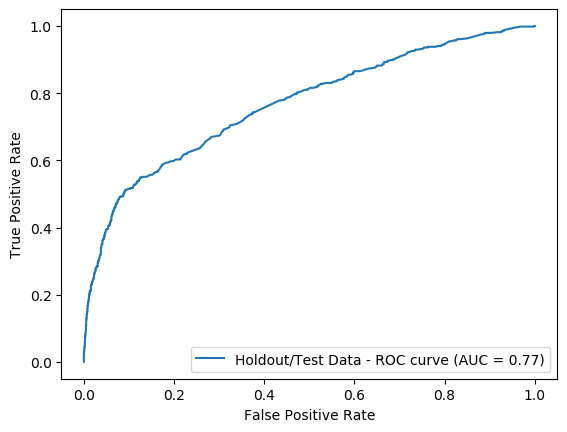

In [48]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
display.plot()
plt.show()

#### Confusion matrix

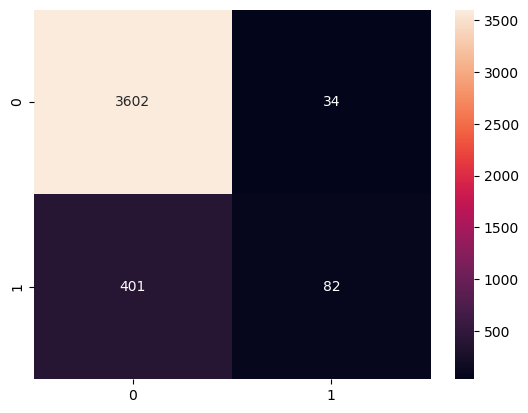

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, np.round(predictions))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#### Precision-recall curve

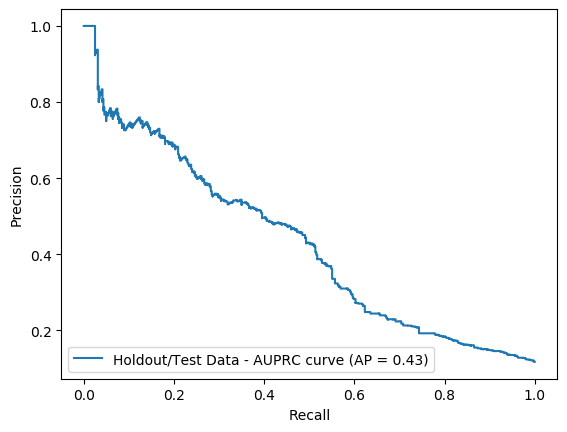

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

### Save charts to the experiment run
You can use the [`experiments.load_run()`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#sagemaker.experiments.load_run) method to load an existing run.

In [51]:
title_suffix = strftime('%Y-%m-%M-%S', gmtime())

with load_run(experiment_name=experiment_name, run_name=run_name) as run:
    print(run.experiment_config)
    run.log_confusion_matrix(y_true=test_y['y'].values,
                             y_pred=np.array(np.round(predictions), dtype=float).squeeze(), 
                             title=f"confusion-matrix-{title_suffix}")
    run.log_roc_curve(y_true=test_y['y'].values, 
                      y_score=predictions['y_prob'].values, 
                      title=f"roc-curve2-{title_suffix}")
    run.log_precision_recall(y_true=test_y['y'].values,
                             predicted_probabilities=predictions['y_prob'].values,
                             positive_label=1,
                             title=f"precision-recall-{title_suffix}")

INFO:sagemaker.experiments.run:The run (batch-transform-2023-02-50-03) under experiment (from-idea-to-prod-experiment-11-22-12-47) already exists. Loading it. Note: sagemaker.experiments.load_run is recommended to use when the desired run already exists.


{'ExperimentName': 'from-idea-to-prod-experiment-11-22-12-47', 'TrialName': 'Default-Run-Group-from-idea-to-prod-experiment-11-22-12-47', 'RunName': 'from-idea-to-prod-experiment-11-22-12-47-batch-transform-2023-02-50-03'}


## Explore experiments and runs with Studio UX
You can see all logged metrics, parameters, and artifacts in Studio UX in **SageMaker Home** > **Experiments** widget.

For example, click on your experiment name you used in this notebook:

![](img/experiment-and-runs.png)

You see runs which you created in this notebook:

![](img/runs-02.png)

Select `batch-transform-<timestamp>` run and choose **Charts** in the **Overview** section on the left pane. You see the three added charts in the run:

![](img/run-charts.png)


---

## Optional: Hyperparameter optimization (HPO)
It takes about 20 minutes to run this section. The section is optional and you don't need to run it to continue with other notebooks. You can navigate directly to step 3 [notebook](03-sagemaker-pipeline.ipynb). If you would like to perform a model A/B test in **Additional topics** sections, you can execute this part to produce an alternative model.

[Amazon SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also called hyperparameter optimization (HPO), finds the best performing model against a defined objective metric by running many training jobs on the dataset using the algorithm and ranges of hyperparameters that you specify. SageMaker HPT supports random search, bayesian optimization, and [hyperband](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) as tuning strategies.

In [124]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [128]:
# set up hyperparameter ranges
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
    "gamma": ContinuousParameter(0, 10)
    
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,  # the SageMaker estimator object
    hyperparameter_ranges=hp_ranges,  # the range of hyperparameters
    max_jobs=30,  # total number of HPO jobs
    max_parallel_jobs=3,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

Now run the HPO job. It takes about 10 minutes to complete. 

<div class="alert alert-info"> 💡 Note, that the HPO job creates its own experiment to track each training job with a specific set of hyperparameters as a separate run.
</div>

In [ ]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
)

INFO:sagemaker:Creating hyperparameter tuning job with name: from-idea-to-prod-hp-230114-1948


...................................................................................!


In [130]:
print(f"HPO job status: {sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']}")

HPO job status: Completed


In [131]:
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)


2023-01-14 19:55:21 Starting - Found matching resource for reuse
2023-01-14 19:55:21 Downloading - Downloading input data
2023-01-14 19:55:21 Training - Training image download completed. Training in progress.
2023-01-14 19:55:21 Uploading - Uploading generated training model
2023-01-14 19:55:21 Completed - Resource reused by training job: from-idea-to-prod-hp-230114-1948-019-c18ebfe7

INFO:sagemaker:Creating model with name: from-idea-to-prod-hp-2023-01-14-20-03-50-465


INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-hp-230114-1948-016-d953caf5
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-hp-230114-1948-016-d953caf5


------!

In [132]:
hpo_predictions = np.array(hpo_predictor.predict(test_x.values), dtype=float).squeeze()
print(hpo_predictions)

[0.04836407 0.11756723 0.20929319 ... 0.03590704 0.03434899 0.03425803]


In [133]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(hpo_predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3600,36
1,394,89


There is no any material improvements for the model metrics. It can indicate, that the XGBoost model is already at it's limit. You might want to explore other model types to improve the prediction accuracy for this use case.

---

## Clean-up
To avoid charges, remove the hosted endpoint you created.

In [52]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-13-09-14-07
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-13-09-14-07


In [135]:
# run if you created a tuned predictor after HPO
hpo_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-hp-230114-1948-016-d953caf5
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-hp-230114-1948-016-d953caf5


## Continue with the step 3
open the step 3 [notebook](03-sagemaker-pipeline.ipynb).

## Further development ideas for your real-world projects
- Track, organize, and compare all your model training runs using [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html)
- Use [Amazon SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) for creating a no-code or low-code visual data processing and feature engineering flow. Refer to this hands-on tutorial: [Prepare Training Data for Machine Learning with Minimal Code](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-prepare-data-with-minimal-code/)
- Try no-code [SageMaker Canvas](https://docs.aws.amazon.com/sagemaker/latest/dg/canvas.html) on your data to perform analysis and use automated ML to build models and generate predictions

## Additional resources
- [Using Docker containers with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)
- [How to create and use a custom SageMaker container: SageMaker hands-on workshop](https://sagemaker-workshop.com/custom/containers.html)
- [Amazon SageMaker Immersion Day](https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US)
- [Targeting Direct Marketing with Amazon SageMaker XGBoost](https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/processing_xgboost.ipynb)
- [Train a Machine Learning Model](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-train-a-model/)
- [Deploy a Machine Learning Model to a Real-Time Inference Endpoint](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/)
- [Amazon SageMaker 101 Workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)
- [Amazon SageMaker 101 Workshop code repository](https://github.com/aws-samples/sagemaker-101-workshop)
- [Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions](https://github.com/aws-samples/sagemaker-101-workshop/blob/main/builtin_algorithm_hpo_tabular/SageMaker%20XGBoost%20HPO.ipynb)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>